In [6]:
# Uninstall and clean install
!pip uninstall -y datasets
!pip install -q datasets --upgrade --no-cache-dir


Found existing installation: datasets 3.6.0
Uninstalling datasets-3.6.0:
  Successfully uninstalled datasets-3.6.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 14.6 MB/s eta 0:00:00


In [8]:
from datasets import load_dataset
dataset = load_dataset("yelp_review_full", split="train[:100]")  # sample
print(dataset[0])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/6.72k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/299M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/23.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

{'label': 4, 'text': "dr. goldberg offers everything i look for in a general practitioner.  he's nice and easy to talk to without being patronizing; he's always on time in seeing his patients; he's affiliated with a top-notch hospital (nyu) which my parents have explained to me is very important in case something happens and you need surgery; and you can get referrals to see specialists without having to see him first.  really, what more do you need?  i'm sitting here trying to think of any complaints i have about him, but i'm really drawing a blank."}


In [9]:
!pip install -q transformers


In [10]:
from transformers import pipeline

# Load sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis")


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


In [11]:
# Apply on first 10 reviews for demonstration
for i in range(10):
    text = dataset[i]["text"]
    result = sentiment_pipeline(text[:512])[0]  # Limit to 512 tokens
    print(f"Review {i+1}: {result['label']} (confidence: {result['score']:.2f})")


Review 1: POSITIVE (confidence: 0.99)
Review 2: NEGATIVE (confidence: 1.00)
Review 3: POSITIVE (confidence: 1.00)
Review 4: NEGATIVE (confidence: 1.00)
Review 5: NEGATIVE (confidence: 1.00)
Review 6: POSITIVE (confidence: 1.00)
Review 7: POSITIVE (confidence: 1.00)
Review 8: NEGATIVE (confidence: 1.00)
Review 9: POSITIVE (confidence: 1.00)
Review 10: NEGATIVE (confidence: 0.98)


In [12]:
results = sentiment_pipeline([example['text'][:512] for example in dataset.select(range(100))])
labels = [r['label'] for r in results]

from collections import Counter
print("Sentiment distribution (first 100 samples):", Counter(labels))


Sentiment distribution (first 100 samples): Counter({'NEGATIVE': 52, 'POSITIVE': 48})


In [13]:
!pip install -q pandas matplotlib seaborn


In [14]:
# Run prediction
texts = [d['text'][:512] for d in dataset]  # limit to 512 tokens
results = sentiment_pipeline(texts)

# Attach predictions to dataset
import pandas as pd

df = pd.DataFrame(dataset)
df['predicted_sentiment'] = [r['label'] for r in results]
df['confidence'] = [r['score'] for r in results]

# Convert original Yelp label (0–4) into "POSITIVE"/"NEGATIVE" for comparison
df['true_sentiment'] = df['label'].apply(lambda x: 'POSITIVE' if x >= 3 else 'NEGATIVE')

df[['text', 'label', 'true_sentiment', 'predicted_sentiment', 'confidence']].head(10)


,text,label,true_sentiment,predicted_sentiment,confidence
0,dr. goldberg offers everything i look for in a...,4,POSITIVE,POSITIVE,0.987475
1,"Unfortunately, the frustration of being Dr. Go...",1,NEGATIVE,NEGATIVE,0.999727
2,Been going to Dr. Goldberg for over 10 years. ...,3,POSITIVE,POSITIVE,0.999611
3,Got a letter in the mail last week that said D...,3,POSITIVE,NEGATIVE,0.999711
4,I don't know what Dr. Goldberg was like before...,0,NEGATIVE,NEGATIVE,0.999327
5,Top notch doctor in a top notch practice. Can'...,4,POSITIVE,POSITIVE,0.999712
6,Dr. Eric Goldberg is a fantastic doctor who ha...,4,POSITIVE,POSITIVE,0.999839
7,I'm writing this review to give you a heads up...,0,NEGATIVE,NEGATIVE,0.996253
8,Wing sauce is like water. Pretty much a lot of...,1,NEGATIVE,POSITIVE,0.999532
9,Decent range somewhat close to the city. The ...,2,NEGATIVE,NEGATIVE,0.982246


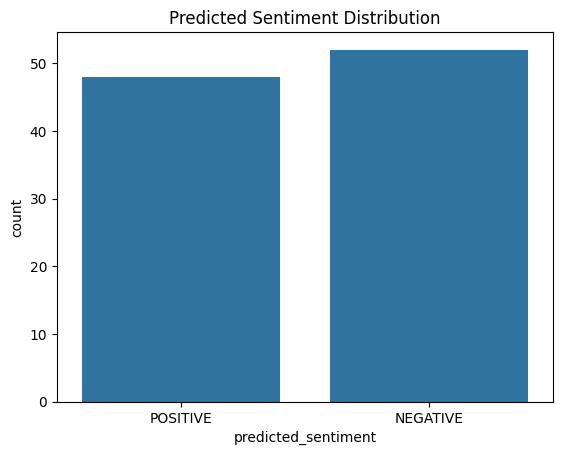

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count predicted sentiments
sns.countplot(x='predicted_sentiment', data=df)
plt.title("Predicted Sentiment Distribution")
plt.show()


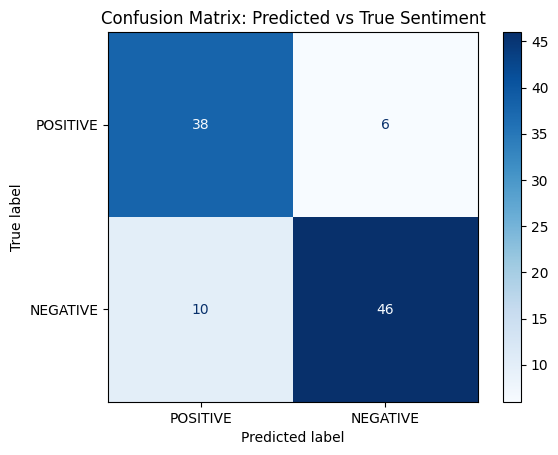

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(df['true_sentiment'], df['predicted_sentiment'], labels=["POSITIVE", "NEGATIVE"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["POSITIVE", "NEGATIVE"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: Predicted vs True Sentiment")
plt.show()


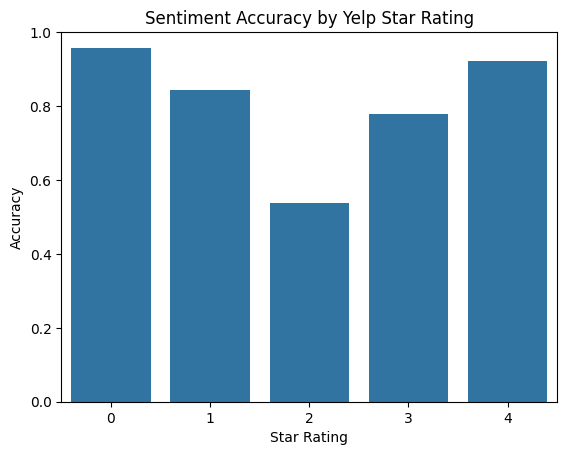

In [17]:
# Accuracy by star rating
df['correct'] = df['true_sentiment'] == df['predicted_sentiment']
grouped = df.groupby('label')['correct'].mean().reset_index()
grouped.columns = ['Star Rating', 'Accuracy']

# Plot
sns.barplot(x='Star Rating', y='Accuracy', data=grouped)
plt.title("Sentiment Accuracy by Yelp Star Rating")
plt.ylim(0, 1)
plt.show()
